<a href="https://colab.research.google.com/github/ZiminPark/recsim_ng/blob/master/RecSim_NG_Dealing_With_Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install edward2
!pip3 install --upgrade -q --no-cache-dir recsim_ng

     |████████████████████████████████| 163kB 5.3MB/s 
     |████████████████████████████████| 143kB 5.0MB/s 


In [9]:
from typing import Any, Callable, Mapping, Sequence, Text
import functools
import matplotlib as mpl
from matplotlib import animation
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import edward2 as ed
from recsim_ng.core import network as network_lib
from recsim_ng.core import variable
from recsim_ng.core import value
from recsim_ng.lib import data
from recsim_ng.lib.tensorflow import entity
from recsim_ng.lib.tensorflow import log_probability
from recsim_ng.lib.tensorflow import runtime
from recsim_ng.core import value

In [10]:
tfd = tfp.distributions
tfb = tfp.bijectors

mpl.style.use("classic")

Variable = variable.Variable
Value = value.Value
FieldSpec = value.FieldSpec

ValueSpec = value.ValueSpec

# Uncertainty in RecSim NG

In [the first tutorial](RecSim_NG_Basics.ipynb) we introduced a RecSim NG model that captured a simple stochastic process expressed using the language of Dynamic Bayesian Networks (DBNs). Yet, throughout the tutorial we explicitly abstained from dealing with *stochasticity*!

In this tutorial, we correct this deficiency and explicitly address the stochastics of the Markov process captured by a DBN.

## Stochastic Simulations

Simulating individual events (e.g., **clicks, ratings, churn**) extremely challenging task that faces many obstacles. 

By far, the most significant challenge is that of **observability**: by some combination of 
- mental state, 
- past experience, 
- personality traits, 
- and environmental factors---

even if we could, modeling the interplay or interaction of multiple users with any degree of fidelity or realism is prohibitively complex. 

Luckily, the questions that we typically aim to answer with simulation rarely require realistically reproducing exact sequences of events. In most cases, we are interested in questions like: 
* "Does policy A induce more user satisfaction than policy B?"
* "Does technique X decrease the disparity in quality of service between niche and mainstream users?"
* "Is this product going to be viable in 5 years?"

and so on. Such questions can be answered using **aggregate statistics**. 
For example, we do not necessarily need to know if a user query for a specific type of content will be answered correctly at a specific time of the day; rather, it may suffice to know that *p*% of a user's queries are answered in a satisfactory fashion. 

This relaxes the requirement of simulating "precise" trajectories of events to that of simulating **"plausible" trajectories** of events---trajectories that contain different types of events in the right contexts in similar proportions to those found in the real world.

In recommendation systems simulation, stochasticity is typically implemented using "stochastic" behaviors. 

That is, given a set of stimuli or inputs (e.g., a slate of recommendations, and a user's context), a **behavioral model** (e.g., a user's response or choice function) generates an outcome (e.g., a click, a rating, a purchase) by sampling from a distribution of possible outcomes conditioned on these stimuli. 

We consider a simulation to be 
> **"plausible"** if it generates events whose relative frequencies are "similar" to those observed in real world data. 

Of course, there is a significant amount of freedom in how we measure similarity for this purpose---we discuss some options later on.  

# Randomness in RecSim NG 

a fairly wide set of cases where imperative definitions can be converted to declarative ones in reasonable time and space, allowing us to have the best of both worlds. 

To achieve this, RecSim NG uses the [Edward2](https://github.com/google/edward2) probabilistic programming environment. Edward2 is a layer on top of [TensorFlow Probability](https://github.com/tensorflow/probability) which employs program transformation to allow us to treat our imperative sampling code as if it were a symbolic declarative definition of the distribution. 

RecSim NG exposes a small (but easily extensible) set of Edward2 program transformations tailored to simulation-specific tasks (including those of special relevance for simulating agents involved in recommender systems).


## Hello Random World

In principle, adding randomness to a RecSim NG simulation can be as easy as encapsulating every random draw in an Edward2 random variable. 

The following code implements a simple Gaussian random walk whose kernel is parameterized by the ```normal_scale``` parameter.


In [4]:
normal_scale = tf.Variable(1.0)


def rw_next(previous_state: Value) -> Value:
  return Value(
      state=ed.Normal(loc=previous_state.get("state"), scale=normal_scale))


random_walk_var = Variable(name="rw_var", spec=ValueSpec(state=FieldSpec()))
random_walk_var.initial_value = variable.value(
    lambda: Value(state=ed.Normal(loc=0.0, scale=1.0)))
random_walk_var.value = variable.value(rw_next, (random_walk_var.previous,))

tf_runtime = runtime.TFRuntime(network=network_lib.Network([random_walk_var]))

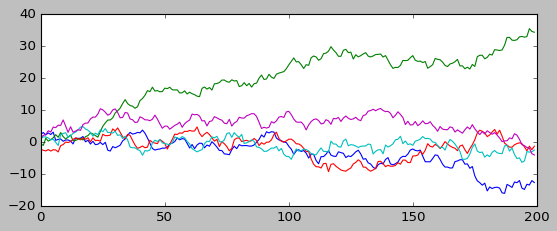

In [5]:
horizon = 200
trajectories = [tf_runtime.trajectory(horizon) for _ in range(5)]
_, ax = plt.subplots(figsize=(8, 3))

for trajectory in trajectories:
  ax.plot(range(horizon), trajectory["rw_var"].get("state"))

We see that different simulator runs result in different random draws, hence different trajectories.

## Beyond Monte Carlo: Evaluating Log-probabilities
The example above illustrates the implementation of a simple stochastic simulation (also known as a *Monte Carlo simulation*) in RecSim NG. As discussed earlier, RecSim offers considerable additional functionality beyond simple trajectory generation. One significant difference between RecSim NG and a pure Monte Carlo simulator is that it can evaluate the probabilities of trajectories according to the DBN induced by the simulation. This functionality is contained in the ```log_probability``` module. 

The ```log_probability``` module offers a number of APIs for evaluating log probabilities of either entire trajectories, or parts thereof (e.g., individual variables or even individual fields, which is often useful when constructing various estimators). 

At the highest level, the ```log_probability_from_value_trajectory``` function 
> takes a collection of RecSim NG simulation variables, a    ```NetworkValueTrajectory```, which provides possible values for these variables, a trajectory length (in case we want a partial evaluation), and 

> outputs the log probability of the values in the trajectory under the variables' initial state and transition distributions.

In [6]:
log_probs = [
    log_probability.log_probability_from_value_trajectory(
        [random_walk_var], traj, horizon - 1).numpy()
    for traj in trajectories
]
print(log_probs)

[-285.8883, -279.028, -287.4228, -298.987, -276.6525]


Note that the log probabilities are also **differentiable** with respect to parameters. For example, 

In [7]:
with tf.GradientTape() as tape:
  log_probs = [
      log_probability.log_probability_from_value_trajectory([random_walk_var],
                                                            traj, 100)
      for traj in trajectories
  ]
  negative_likelihood = -tf.reduce_sum(log_probs)
grad = tape.gradient(negative_likelihood, normal_scale)
print(grad)

tf.Tensor(29.965141, shape=(), dtype=float32)


# Putting It All Together: User Model Learning

In this section, we showcase how the **uncertainty** APIs of RecSim NG can be used within a recommender-system model-learning application. 

In this scenario, we envision a number of users repeatedly interacting with a recommender. Each interaction proceeds as follows: the **recommender serves a slate (small set) of recommended item** to each user; each **user examines their slate and responds to it in some way (e.g., by clicking, rating or consuming an item in the case of content)**; each user then **updates their own (latent) state**; finally, the recommender observes each user's responses.

The RecSim NG tasks we consider **focus on the inference of the parameters of the *user model*,** comprising models which specify their choice/response behaviors and how they update their state. We **assume there is a "ground truth" user model with specific parameter values, which is used to generate trajectories**. These trajectories will be used to fit a second instantiation of the user model---think of this as the model of user behavior a recommender system might build to optimize its performance---with the same structure, but with unknown parameter values. We consider two flavors of problem: the easy case is where the trajectory data contains all simulation variables, including those that model "mental processes" of the user; and the more involved, but more realistic, case in which some random variables are not made available in the trajectories. The latter case reflects the situation faced by most recommender systems, which cannot directly observe a user's latent state (e.g., her interests, level of satisfaction, etc.).

For simplicity of presentation, we hardcode some parameter values directly into the model. A version of this example can also be found at ```recsim_ng.applications.latent_variable_model_learning```, where most parameter values are configurable.



## The User Model

In our simulated world, we assume that each **recommendable item can be represented in a 2-dimensional Euclidean space**. 

**A user has a *state* consisting of**:
* an *intent* realized by a target item: we assume the user has some goal in mind, expressible as an "ideal" point within the same space in which the items are embedded. The intent induces a preference model according to which items closer to the user's intent are preferred to those which are further away.
* a dynamic *satisfaction* variable $s$, which reflects the user's (personal or subjective) assessment of whether the recommender makes progress towards the target.

When presented with a slate of recommended items, the user's *choice process* either selects an item for consumption, using the sum of item affinities (computed as the negative Euclidean distance between the item and the intent) and satisfaction as logits, or abstain according to a constant "no choice" logit (which we set to 0 for simplicity). The user's satisfaction acts as a boost to the item-level logits compared to the constant "no choice" logit; thus, at high levels of satisfaction, the user is more likely to select some item for consumption. If the user's satisfaction drops and no good items are found, the user effectively "drops out" of the system (i.e., the probability of choosing anything other than "no choice" becomes negligible).

The user state updates as follows:
* The intent is sampled from a mixture model with component means $[1.0, 0.0]^T, [0.0, 1.0]^T$. This distribution over intents remains fixed over time.
* Satisfaction $s$ evolves as: $$s_t = \mathrm{satisfaction\ sensitivity} \cdot s_{t-1} + \delta_t + \epsilon,$$ where: satisfaction sensitivity is a parameter (set to 0.8 in this case); **$\delta_t$ is the difference between the maximum affinity among the items from the slate presented at time $t$ and the maximum of the  time $(t-1)$ slate**; and $\epsilon$ is zero-mean Gaussian noise with standard deviation of $0.1$.

This model is implemented below using intent, choice, and affinity model implementations provided by the RecSim NG library.



In [12]:
from recsim_ng.stories import recommendation_simulation as simulation
from recsim_ng.applications.latent_variable_model_learning import recommender
from recsim_ng.entities.recommendation import user
from recsim_ng.entities.state_models import static
from recsim_ng.entities.choice_models import selectors
from recsim_ng.entities.choice_models import affinities

In [13]:
class ModelLearningDemoUser(user.User):

  def __init__(self,
               config: Mapping[Text, Any],
               satisfaction_sensitivity: tf.Tensor,
               name: Text = 'ModelLearningDemoUser') -> None:
    super().__init__(config, name)
    self._slate_size = config.get('slate_size')
    # Hardcoded parameter values.
    self._user_intent_variance = 0.1
    self._initial_satisfication = 5.0
    # Unknown satisfaction sensitivity.
    self._sat_sensitivity = satisfaction_sensitivity
    # The intent model as a GMM state model from the RecSim NG state
    # model library.
    batch_intent_means = tf.eye(
        2, num_columns=2, batch_shape=(self._num_users,))
    lop_ctor = lambda params: tf.linalg.LinearOperatorScaledIdentity(
        num_rows=2, multiplier=params)
    self._intent_model = static.GMMVector(
        batch_ndims=1,
        mixture_logits=tf.zeros((self._num_users, 2)),
        component_means=batch_intent_means,
        component_scales=tf.sqrt(self._user_intent_variance),
        linear_operator_ctor=lop_ctor)
    # The choice model is a multinomial logit choice model from the RecSim NG
    # choice model library.
    self._choice_model = selectors.MultinomialLogitChoiceModel(
        batch_shape=(self._num_users,),
        nochoice_logits=tf.ones(self._num_users))
    # The affinity model is a target point similarity model, which by default
    # computes the negative Euclidean distance between the target point and the
    # item embedding.
    self._affinity_model = affinities.TargetPointSimilarity(
        batch_shape=(self._num_users,), slate_size=self._slate_size)

  def initial_state(self) -> Value:
    """Initial state value."""
    return Value(
        satisfaction=ed.Deterministic(self._initial_satisfication *
                                      tf.ones(self._num_users)),
        intent=self._intent_model.initial_state().get('state'),
        max_slate_utility=tf.zeros(self._num_users))

  def next_state(self, previous_state: Value, _, slate_docs: Value) -> Value:
    """State transition kernel."""
    # Compute the improvement of slate scores.
    slate_doc_features = slate_docs.get('features')
    slate_doc_affinities = self._affinity_model.affinities(
        previous_state.get('intent'), slate_doc_features).get('affinities')
    max_slate_utility = tf.reduce_max(slate_doc_affinities, axis=-1)
    improvement = max_slate_utility - previous_state.get('max_slate_utility')
    next_satisfaction = self._sat_sensitivity * previous_state.get(
        'satisfaction') + improvement
    return Value(
        satisfaction=ed.Normal(loc=next_satisfaction, scale=0.01),
        intent=self._intent_model.next_state(
            Value(state=previous_state.get('intent'))).get('state'),
        max_slate_utility=max_slate_utility)

  def next_response(self, previous_state: Value, slate_docs: Value) -> Value:
    """The response value after the initial value."""
    slate_doc_features = slate_docs.get('features')
    slate_doc_scores = self._affinity_model.affinities(
        previous_state.get('intent'), slate_doc_features).get('affinities')
    # Adding the user's satisfaction to the item scores.
    adjusted_scores = (
        slate_doc_scores + previous_state.get('satisfaction')[..., tf.newaxis])
    return self._choice_model.choice(adjusted_scores)

  def observation(self):
    pass

  def specs(self) -> ValueSpec:
    response_spec = self._choice_model.specs()
    state_spec = ValueSpec(
        intent=self._intent_model.specs().get('state'),
        satisfaction=FieldSpec(),
        max_slate_utility=FieldSpec())
    return state_spec.prefixed_with('state').union(
        response_spec.prefixed_with('response'))

In [14]:
# Initialize simulation parameters
gt_satisfaction_sensitivity = 0.8 * tf.ones(5)
num_users = 5
num_topics = 2
horizon = 6

config = {
    "slate_size": 2,
    "num_users": num_users,
    "num_topics": num_topics,
    "num_docs": 0
}
# Set up ground truth runtime.
gt_user_ctor = functools.partial(
      ModelLearningDemoUser,
      satisfaction_sensitivity=gt_satisfaction_sensitivity)
gt_variables = simulation.simplified_recs_story(config, gt_user_ctor,
                                          recommender.SimpleNormalRecommender)
gt_network = network_lib.Network(variables=gt_variables)
gt_runtime = runtime.TFRuntime(network=gt_network)
traj = dict(gt_runtime.trajectory(length=horizon))
print('===============GROUND TRUTH LIKELIHOOD================')
print(
    log_probability.log_probability_from_value_trajectory(
        variables=gt_variables, value_trajectory=traj, num_steps=horizon - 1))
print('======================================================')

===============GROUND TRUTH LIKELIHOOD================
tf.Tensor(-57.91516, shape=(), dtype=float32)


In [15]:
trainable_sat_sensitivity = tf.Variable(
    tf.math.sigmoid(ed.Normal(loc=tf.zeros(5), scale=1.0)))
trainable_user_ctor = functools.partial(
    ModelLearningDemoUser, satisfaction_sensitivity=trainable_sat_sensitivity)
t_variables = simulation.simplified_recs_story(
    config, trainable_user_ctor, recommender.SimpleNormalRecommender)
trainable_network = network_lib.Network(variables=t_variables)
trainable_runtime = runtime.TFRuntime(network=trainable_network)
print('===============UNTRAINED LIKELIHOOD================')
print(
    log_probability.log_probability_from_value_trajectory(
        variables=t_variables, value_trajectory=traj, num_steps=horizon - 1))
print('======================================================')

===============UNTRAINED LIKELIHOOD================
tf.Tensor(-69400.414, shape=(), dtype=float32)


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def training_step():
  with tf.GradientTape() as tape:
    gt_trajectory = gt_runtime.trajectory(length=horizon)
    neg_likelihood = -log_probability.log_probability_from_value_trajectory(
        variables=t_variables, value_trajectory=traj, num_steps=horizon - 1)
  grads = tape.gradient(neg_likelihood, [trainable_sat_sensitivity])
  optimizer.apply_gradients(zip(grads, [trainable_sat_sensitivity]))
  return neg_likelihood

likelihood_history = []
print(f"Parameters before training: {trainable_sat_sensitivity.numpy()}")
for i in range(101):
  obj = training_step()
  likelihood_history.append(-obj)
  if not i % 20:
    print(f"Iteration {i}, negative likelihood {obj.numpy()}")
    print(f"Parameter values: {trainable_sat_sensitivity.numpy()}")

Parameters before training: [0.307318   0.7299073  0.715353   0.544816   0.84736717]
Iteration 0, negative likelihood 69400.4140625
Parameter values: [0.317318   0.73990726 0.725353   0.554816   0.8373672 ]
Iteration 20, negative likelihood 20559.65234375
Parameter values: [0.51019996 0.80448884 0.8180659  0.7369146  0.8060292 ]
Iteration 40, negative likelihood 4475.8740234375
Parameter values: [0.66515666 0.80142766 0.7948264  0.81823367 0.79603547]
Iteration 60, negative likelihood 492.6428527832031
Parameter values: [0.7590997  0.79578453 0.7979844  0.8048417  0.7966165 ]
Iteration 80, negative likelihood 60.832359313964844
Parameter values: [0.79729235 0.7969965  0.80007654 0.79403156 0.79751587]
Iteration 100, negative likelihood 58.455474853515625
Parameter values: [0.80424523 0.79764223 0.79909855 0.7980509  0.79789823]


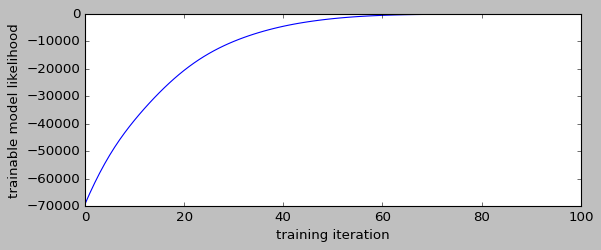

In [17]:
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(len(likelihood_history)), likelihood_history)
plt.xlabel('training iteration')
plt.ylabel('trainable model likelihood')
plt.show()

## Partially observed data.

Model learning problems like the one above, where all random variables are observed in every trajectory, are relatively straightforward to solve (at least conceptually). However, in many real-world applications, especially those concerning recommender systems, we cannot expect to observe everything that goes on in the domain of interest. This is true almost by definition in the realm of *user modeling*, where the tools needed to understand users' behaviors tend to be psychometric constructs, such as preferences, interests, personality characteristics, mood/sentiment, and so on. These are hypothesized to "exist" only in the user's mind and can only be inferred via the observed behaviors which they influence. Other unobservable characteristics involving the user's context or environment may also influence their behavior in a recommendation setting (e.g., context variables like the user's location, their activity, and their companions).

> Learning simulators from **partially observed data** is still possible, though not as straightforward as in the fully observed case. 


## Latent Variable Model

There are several well-understood ways to train a latent variable model for use as a simulator. For the purposes of this tutorial, we implement a classical technique called *Expectation-Maximization (EM)*. 

Let $X$ be the set of observed variables, $Y$ be the set of unobserved variables, and $\theta$ be the set of model parameters. In the fully observed case ($Y = \emptyset$), one natural approach is to find parameters that maximize the plausibility of the observed data $X$ by maximizing the log-likelihood:
$$\theta^\ast = \arg\max_\theta \log p_\theta(X).$$

 The starting point of EM is to extend the idea of maximizing log-marginal likelihood of $X$ by integrating out $Y$:
 $$\theta^* = \arg\max_\theta \log \int_Y p_\theta(X,Y).$$
Algorithmically, this is done by constructing a sequence of lower bounds
$$ f(\theta; \theta_k) = \int_Y p_{\theta^k}(Y|X)\log p_\theta(X,Y) + H_{\theta^k} \leq \log \int_Y p_\theta(X,Y),$$
where $\theta^k$ is the parameter guess at step $k$, and $H_{\theta^k}$ is a quantity dependent on $\theta_k$, which can be ignored for our particular purposes. 

A "vanilla" EM iteration (e.g., step $k+1$) typically proceeds in two phases:
1. Compute $f(\theta; \theta_k)$ (E-step).
2. Update parameters as $\theta_{k+1} = \arg\max_\theta f(\theta; \theta_k)$ (M-step).

There are two challenges to address before we can put this into action: first, we need a tractable way of computing (possibly approximating) the posterior expectation over $Y|X$ in the E-step. Second, we need to be able to compute (again, approximate) the argmax parameters in the M-step. 

The first challenge will be addressed using *posterior sampling*. Specifically, we replace the expectation $\int_Y p_{\theta^k}(Y|X)\log p_\theta(X,Y)$ by a Monte-Carlo estimate $\frac{1}{|S|}\sum_{s\in S} \log p_\theta(X,Y_s)$, where $\{Y_1,\ldots, Y_s\}$ are samples from the posterior distribution $p(\cdot|X)$. The second challenge is addressed using gradient ascent on $\theta$. In fact, we just replace step 2 by a *single* gradient step instead of running gradient descent to convergence every time (this works fine in our case---surprise, surprise---but, in general, how much and what type of maximization is realized in step 2 may change the convergence properties of the algorithm).

We already know how to perform gradient ascent on parameter likelihoods, so what remains to show is how to implement posterior sampling with RecSim NG.

## posterior sampling
Our posterior sampling implementation uses a *Markov-Chain Monte Carlo (MCMC)* sampler provided by TFP. MCMC is a family of algorithms for sampling from an unnormalized density---such methods start at some point in the support of the density and incrementally perturb that point using information from the density. 

We use the *Hamiltonian Monte Carlo (HMC)* approach, which stochastically moves the sample in the direction of the gradient of the log probability function. TFP already offers a robust implementation of HMC, so our job is only to provide its inputs.

To illustrate latent variable model learning, let's assume that every user's intent is an *unobserved* variable, while all other parts of the trajectory are given. To use TFP's HMC implementation, we need to implement the unnormalized (log) density $\phi(Y) := \log p(X,Y)$, where $Y$ is the array consisting of the users' intents. Moreover, $\phi(Y)$ must be differentiable with respect to $Y$. This is relatively straightforward in RecSim NG. Since the user intent doesn't change over time, we can recreate the intent trajectory by expanding the intent vector over time. Then, we combine that intent trajectory with the observed data and call the log prob function. The implementation is given below.

In [18]:
# Reinitialize trainable variables.
trainable_sat_sensitivity.assign(
    tf.math.sigmoid(ed.Normal(loc=tf.zeros(5), scale=1.0)))


@tf.function
def unnormalized_log_prob_train(intent: tf.Tensor) -> tf.Tensor:
  # Expand initial intent to complete intent trajectory.
  intent_traj = tf.expand_dims(
      intent, axis=0) + tf.zeros((horizon, num_users, num_topics))
  # Combine intent trajectory with the observed data.
  user_state_dict = dict(traj['user state'].as_dict)
  user_state_dict['intent'] = intent_traj
  traj['user state'] = Value(**user_state_dict)
  # Return the log probability of the imputed intent + observations.
  return log_probability.log_probability_from_value_trajectory(
      variables=t_variables, value_trajectory=traj, num_steps=horizon - 1)

With the unnormalized density implementation, setting up the HMC sampler follows the TFP [HamiltonianMonteCarlo example code](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo) almost verbatim.

In [19]:
num_results = int(2e3)
num_burnin_steps = int(5e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob_train,
        num_leapfrog_steps=5,
        step_size=.00008),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=tfd.Normal(loc=tf.ones((5, 2)) / 5, scale=0.5).sample(),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return samples, sample_mean, sample_stddev, is_accepted

In [20]:
#@test {"skip": true}
# Initialize the HMC transition kernel.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
elbo_history = []
for i in range(101):
  posterior_samples, sample_mean, sample_stddev, is_accepted = run_chain()
  log_probs = []
  with tf.GradientTape() as tape:
    log_probs = tf.vectorized_map(unnormalized_log_prob_train,
                                  posterior_samples[num_burnin_steps:,])
    neg_elbo = -tf.reduce_mean(log_probs)
  grads = tape.gradient(neg_elbo, [trainable_sat_sensitivity])
  optimizer.apply_gradients(zip(grads, [trainable_sat_sensitivity]))
  elbo_history.append(-neg_elbo)
  if not i % 5:
    print(f"Iteration {i}, unnormalized negative ELBO {neg_elbo.numpy()}")
    print(f"Parameter values: {trainable_sat_sensitivity.numpy()}")
    print(f"Acceptance rate: {is_accepted.numpy()}")

Iteration 0, unnormalized negative ELBO 48350.36328125
Parameter values: [0.8501614  0.79987717 0.47942793 0.40078646 0.46324602]
Acceptance rate: 0.9154999852180481
Iteration 5, unnormalized negative ELBO 34882.6875
Parameter values: [0.8620221  0.7748786  0.5291573  0.44856375 0.51268923]
Acceptance rate: 0.7994999885559082


KeyboardInterrupt: ignored

Text(0, 0.5, 'ELBO')

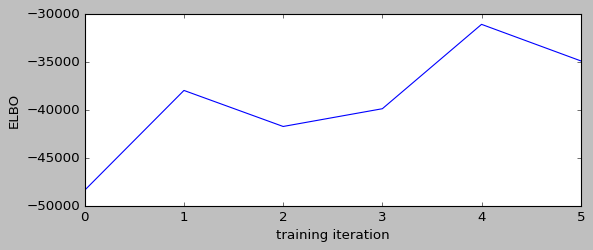

In [21]:
#@test {"skip": true}
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(len(elbo_history)), elbo_history)
plt.xlabel('training iteration')
plt.ylabel('ELBO')